In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colormaps
import imageio.v2 as imageio
import io
import numpy as np
import xarray as xr
import subprocess
from common import set_plot_style, load_font


In [2]:
ROOT_FOLDER = Path("/home/robin/projects/TEDx/")

hist_files = list((ROOT_FOLDER / "data" / "MSL_historical").glob("*.nc"))
fut_85_files = list((ROOT_FOLDER / "data" / "MSL_future_85").glob("*.nc"))

countries_vectorial = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_BN_10M_2020_4326.geojson"
)
countries_name = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_AT_2020.csv"
)

images_dir = Path(ROOT_FOLDER / "output" / "images" / "sea_level_rise")
images_dir.mkdir(parents=True, exist_ok=True)

gif_dir = Path(ROOT_FOLDER / "output" / "gif" / "sea_level_rise")
gif_dir.mkdir(parents=True, exist_ok=True)

lat_min, lat_max = 35, 47
lon_min, lon_max = 5, 20

set_plot_style()
load_font()


In [3]:
ds_hist = xr.open_mfdataset(hist_files)
ds_85 = xr.open_mfdataset(fut_85_files)

In [4]:
# Load world map data
world = gpd.read_file(countries_vectorial)
world_names = gpd.pd.read_csv(countries_name)
world = world.join(world_names.set_index("CNTR_ID"), on="CNTR_CODE", how="left")

# Filter for Mediterranean countries
mediterranean_countries = [
    "Spain",
    "France",
    "Italy",
    "Slovenia",
    "Croatia",
    "Bosnia and Herzegovina",
    "Montenegro",
    "Albania",
    "Greece",
    "Turkey",
    "Syria",
    "Lebanon",
    "Israel",
    "Egypt",
    "Libya",
    "Tunisia",
    "Algeria",
    "Morocco",
]
mediterranean = world[world["NAME_ENGL"].isin(mediterranean_countries)]

In [5]:
latina_box = gpd.read_file(
    """
    {
        "type": "FeatureCollection",
        "features": [
            {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                [
                    [
                    12.721649255827458,
                    41.50041373030399
                    ],
                    [
                    12.721649255827458,
                    41.2
                    ],
                    [
                    13.2,
                    41.2
                    ],
                    [
                    13.2,
                    41.50041373030399
                    ],
                    [
                    12.721649255827458,
                    41.50041373030399
                    ]
                ]
                ],
                "type": "Polygon"
            }
            }
        ]
    }
    """
)

In [6]:
# Concatenate ds_hist and ds_85 along the time dimension
ds = xr.concat([ds_hist, ds_85], dim='time')

# Sort the dataset by time to ensure chronological order
ds = ds.sortby('time')

In [7]:
x_coord = ds.station_x_coordinate.values
y_coord = ds.station_y_coordinate.values

In [8]:
vmin = np.percentile(ds.MSL.values, 10)
vmax = np.percentile(ds.MSL.values, 90)

images = []

# Create the directory if it doesn't exist

for time in ds.time.values:
    print(time)
    fig, ax = plt.subplots(figsize=(5, 5))
    mediterranean.plot(ax=ax, color="grey", zorder=0)
    latina_box.plot(ax=ax, edgecolor="red", facecolor="none", zorder=5)
    sea_level = ds.MSL.sel(time=time).values
  
    scatter = ax.scatter(
        x_coord,
        y_coord,
        c=sea_level,
        cmap="viridis_r",
        vmin=vmin,
        vmax=vmax,
        marker=".",
        s=2,  # markersize
    )
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Livello del mare (m)')
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel("Longitudine")
    ax.set_ylabel("Latitudine")
    ax.set_title(f"Anno {str(time)[:4]}")
    
    # Save the plot locally
    filename = images_dir / f'sea_level_{str(time)[:4]}.png'
    plt.savefig(filename, format='png')
    plt.close(fig)
    images.append(imageio.imread(filename))

1950-01-01T00:00:00.000000000
1951-01-01T00:00:00.000000000
1952-01-01T00:00:00.000000000
1953-01-01T00:00:00.000000000
1954-01-01T00:00:00.000000000
1955-01-01T00:00:00.000000000
1956-01-01T00:00:00.000000000
1957-01-01T00:00:00.000000000
1958-01-01T00:00:00.000000000
1959-01-01T00:00:00.000000000
1960-01-01T00:00:00.000000000
1961-01-01T00:00:00.000000000
1962-01-01T00:00:00.000000000
1963-01-01T00:00:00.000000000
1964-01-01T00:00:00.000000000
1965-01-01T00:00:00.000000000
1966-01-01T00:00:00.000000000
1967-01-01T00:00:00.000000000
1968-01-01T00:00:00.000000000
1969-01-01T00:00:00.000000000
1970-01-01T00:00:00.000000000
1971-01-01T00:00:00.000000000
1972-01-01T00:00:00.000000000
1973-01-01T00:00:00.000000000
1974-01-01T00:00:00.000000000
1975-01-01T00:00:00.000000000
1976-01-01T00:00:00.000000000
1977-01-01T00:00:00.000000000
1978-01-01T00:00:00.000000000
1979-01-01T00:00:00.000000000
1980-01-01T00:00:00.000000000
1981-01-01T00:00:00.000000000
1982-01-01T00:00:00.000000000
1983-01-01

In [9]:
# Create and save the GIF
imageio.mimsave(gif_dir / "sea_level_rise.gif", images, fps=2)

In [10]:
subprocess.run(
    f"gifsicle --colors 64 -O3 {gif_dir / 'sea_level_rise.gif'} -o {gif_dir / 'sea_level_rise_optimized.gif'}",
    shell=True,
    check=True,
)

gifsicle: warning: huge GIF, conserving memory (processing may take a while)


CompletedProcess(args='gifsicle --colors 64 -O3 /home/robin/projects/TEDx/output/gif/sea_level_rise/sea_level_rise.gif -o /home/robin/projects/TEDx/output/gif/sea_level_rise/sea_level_rise_optimized.gif', returncode=0)

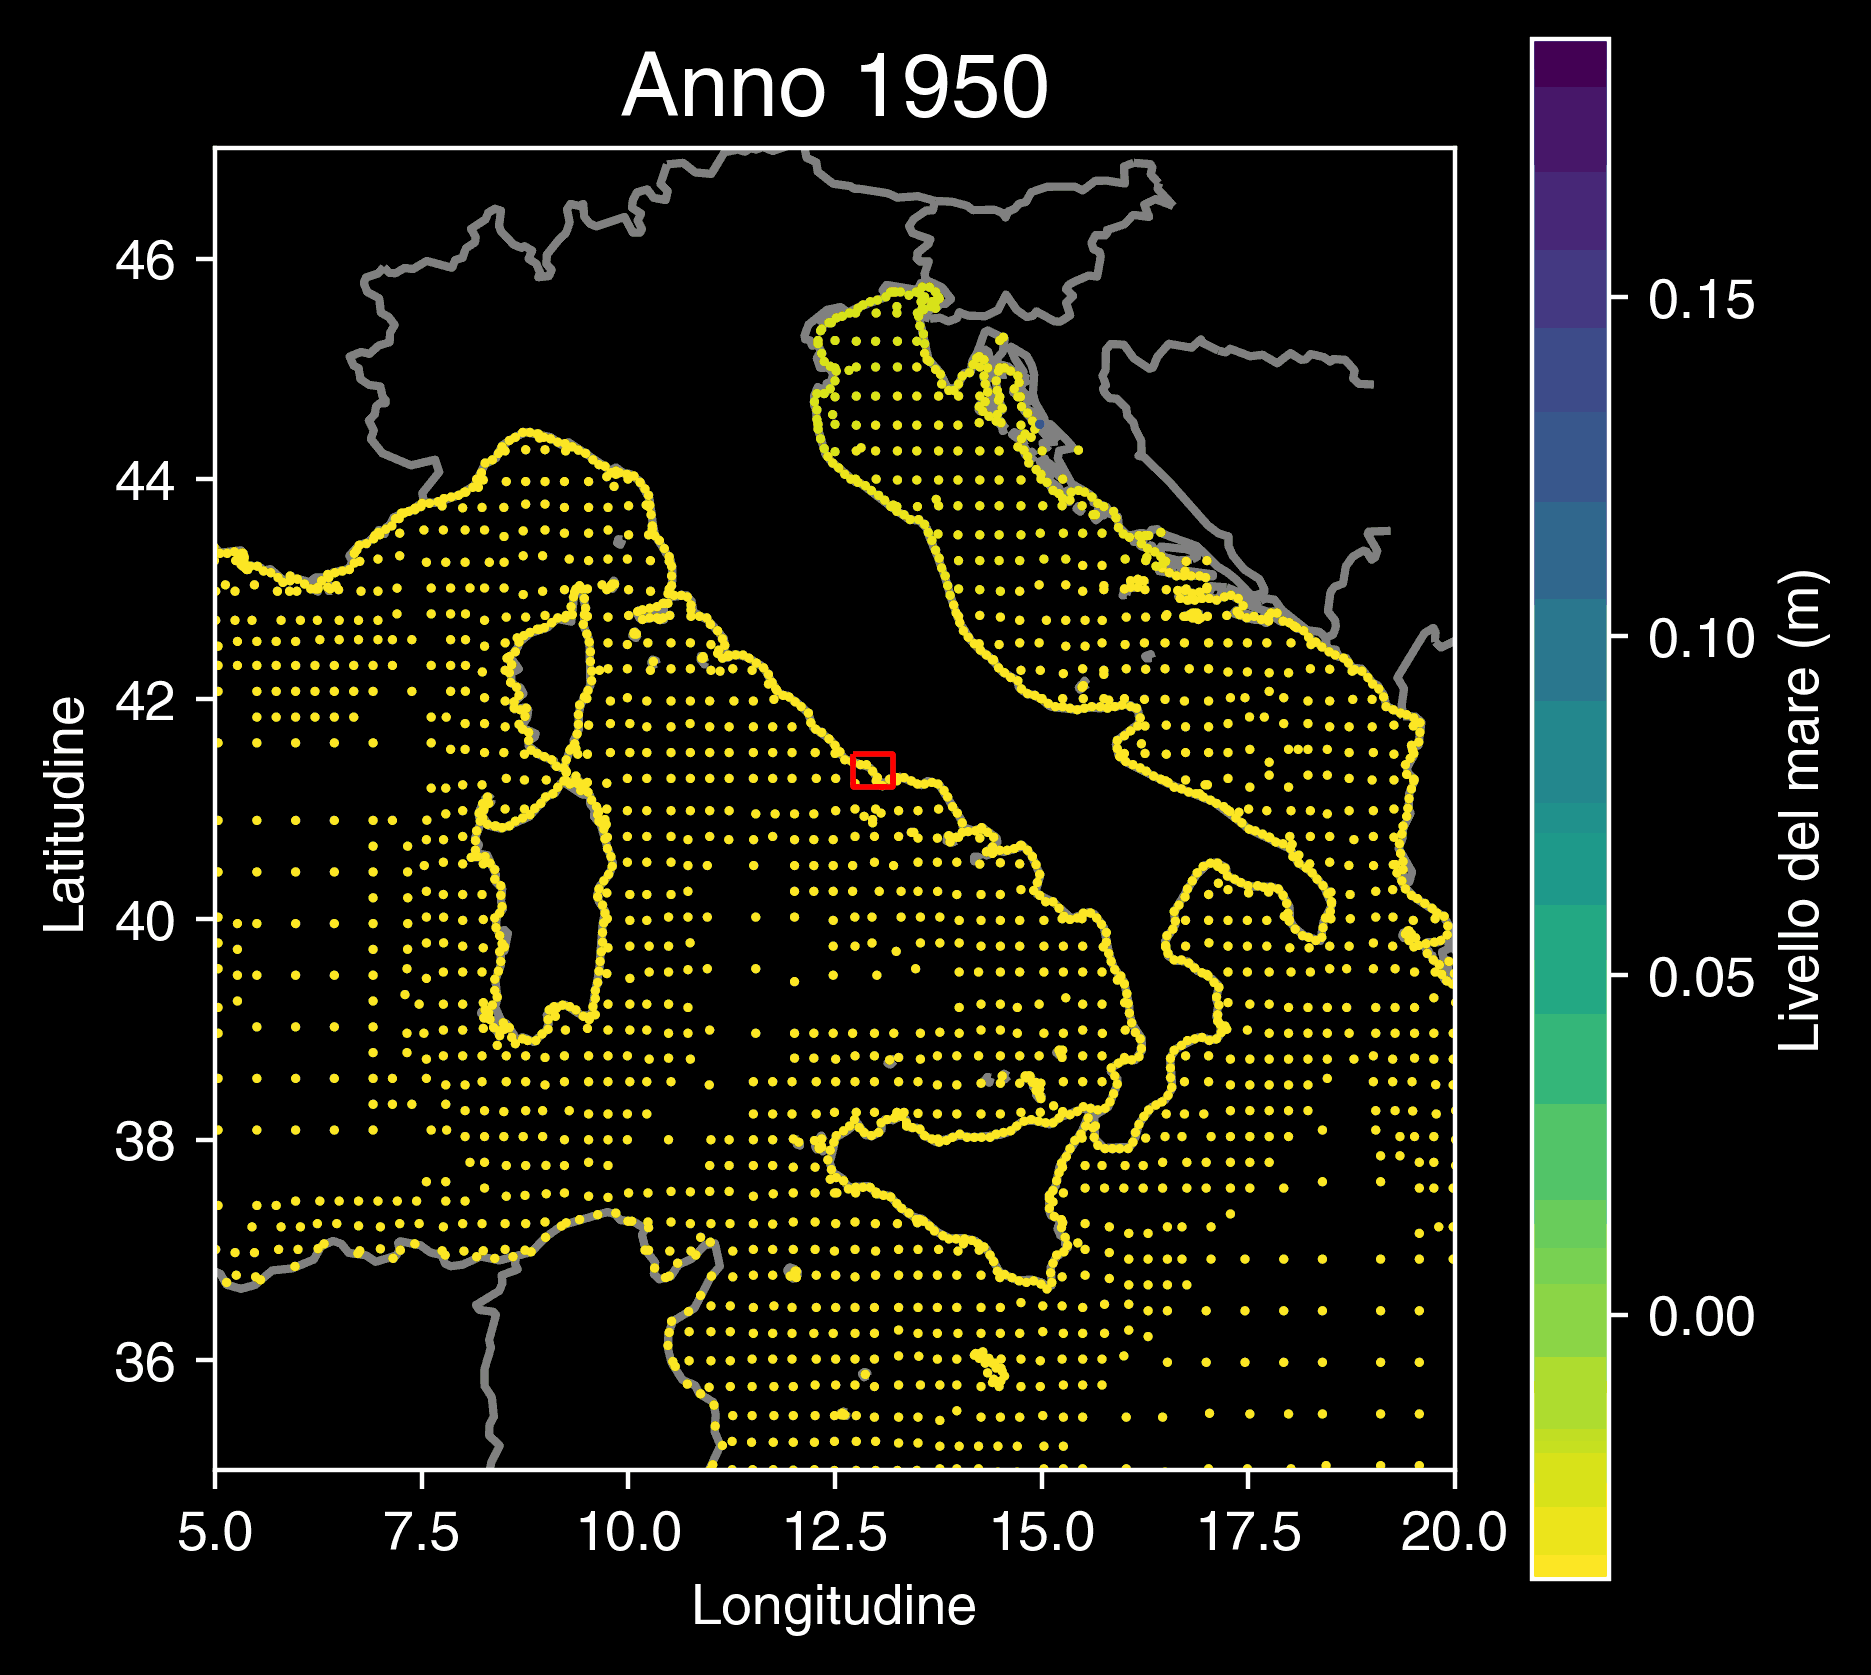

In [11]:
# Display the GIF
from IPython.display import Image

Image(filename=gif_dir / "sea_level_rise_optimized.gif")